In [226]:

import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

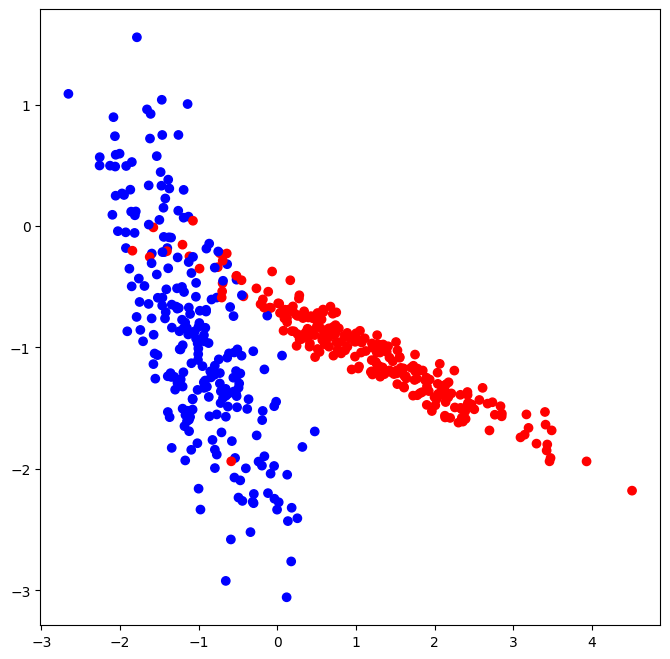

In [227]:

# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [228]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        idx = np.random.choice(n_samples, n_samples, replace=True)
        b_data = data[idx]
        b_labels = labels[idx]

        bootstrap.append((b_data, b_labels))

    return bootstrap
     

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return np.array(subsample)

In [229]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        classes, counts = np.unique(self.labels, return_counts=True)
        prediction = classes[np.argmax(counts)]
        return prediction


def gini(labels):
    if len(labels) == 0:
        return 0
    
    classes, counts = np.unique(labels, return_counts=True)
    p = counts / len(labels)
    
    impurity = np.sum(p*(1-p))
    return impurity


def quality(left_labels, right_labels, current_gini):
    p = len(left_labels) / (len(left_labels) + len(right_labels))
    
    quality = current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return quality


def split(data, labels, index, t):
    mask = data[:, index] <= t
    
    true_data = data[mask]
    false_data = data[~mask]
    true_labels = labels[mask]
    false_labels = labels[~mask]
    
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    # Обозначим минимальное количество объектов в узле
    min_leaf = 1
    
    current_gini = gini(labels)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        unique_values = np.unique(data[:, index])
        
        for i in range(len(unique_values) - 1):
            t = (unique_values[i] + unique_values[i + 1]) / 2
            
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index
    
    return best_quality, best_t, best_index


# Построение дерева посредством рекурсивной функции
def build_tree(full_data, labels, max_depth=10, depth=0):
    if depth >= max_depth or len(np.unique(labels)) == 1 or len(labels) < 10:
        return Leaf(full_data, labels)
    data = full_data[:, np.unique(get_subsample(full_data.shape[1]))]
    best_quality, best_t, best_index = find_best_split(data, labels)
    
    if best_quality <= 0 or best_t is None:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)
    
    true_branch = build_tree(true_data, true_labels, max_depth, depth + 1)
    false_branch = build_tree(false_data, false_labels, max_depth, depth + 1)
    
    return Node(best_index, best_t, true_branch, false_branch)


# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    return np.apply_along_axis(lambda x: classify_object(x, tree), axis=1, arr=data)


In [230]:
def random_forest(data, labels, n_trees, use_bootstrap=False):
    forest = []
    bootstrap = None
    if use_bootstrap:
        bootstrap = get_bootstrap(data, labels, n_trees)

    for i in range(n_trees):
        if not (bootstrap is None):
            forest.append(build_tree(bootstrap[i][0], bootstrap[i][1]))
        else:
            forest.append(build_tree(data, labels))
    
    return forest


def mode(x):
    unique, counts = np.unique(x, return_counts=True)
    return unique[np.argmax(counts)]

def tree_vote(forest, data):

    result = np.array([predict(data, x) for x in forest])

    return np.apply_along_axis(mode, axis=0, arr=result)


In [231]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)
     

  # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0
     

def egg(n_trees):
  my_forest_1 = random_forest(train_data, train_labels, n_trees)

  # Получим ответы для обучающей выборки
  train_answers = tree_vote(my_forest_1, train_data)

  # И получим ответы для тестовой выборки
  test_answers = tree_vote(my_forest_1, test_data)

  # Точность на обучающей выборке
  train_accuracy = accuracy_metric(train_labels, train_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

  # Точность на тестовой выборке
  test_accuracy = accuracy_metric(test_labels, test_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
     
  # Визуализируем дерево на графике

  def get_meshgrid(data, step=.05, border=1.2):
      x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
      y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
      return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

  plt.figure(figsize = (16, 7))

  # график обучающей выборки
  plt.subplot(1,2,1)
  xx, yy = get_meshgrid(train_data)

  mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
  plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
  plt.title(f'Train accuracy={train_accuracy:.2f}')

  # график тестовой выборки
  plt.subplot(1,2,2)
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
  plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
  plt.title(f'Test accuracy={test_accuracy:.2f}')
  plt.show()

Точность случайного леса из 1 деревьев на обучающей выборке: 97.714
Точность случайного леса из 1 деревьев на тестовой выборке: 88.000


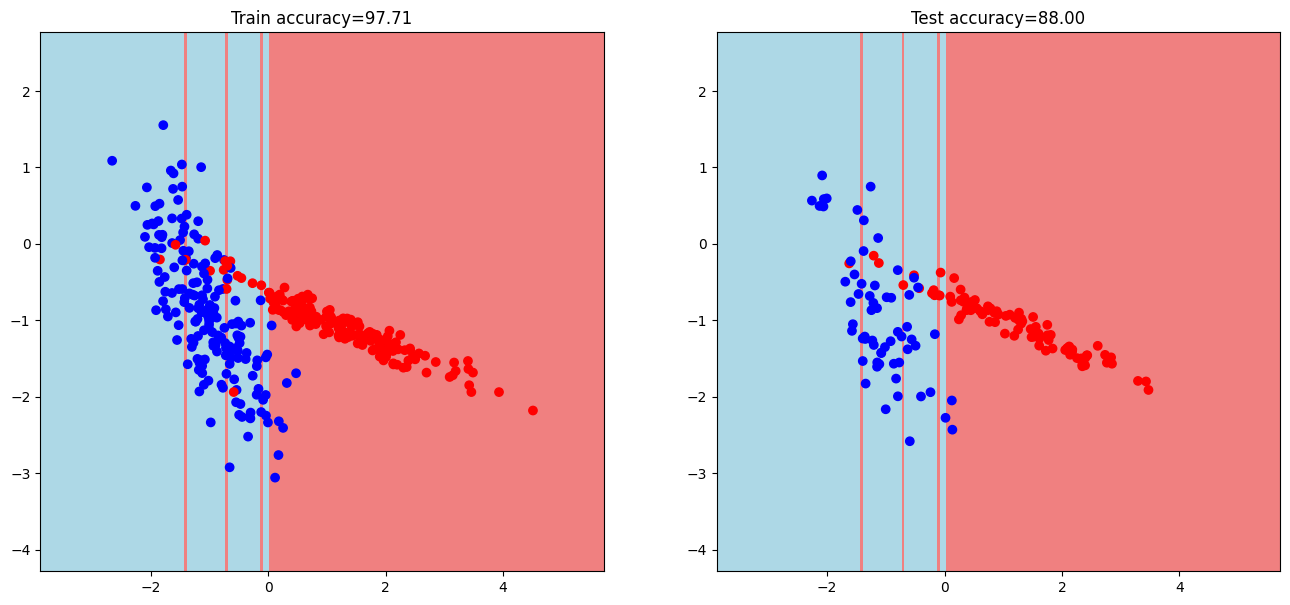

In [232]:
egg(1)

Точность случайного леса из 3 деревьев на обучающей выборке: 97.714
Точность случайного леса из 3 деревьев на тестовой выборке: 88.000


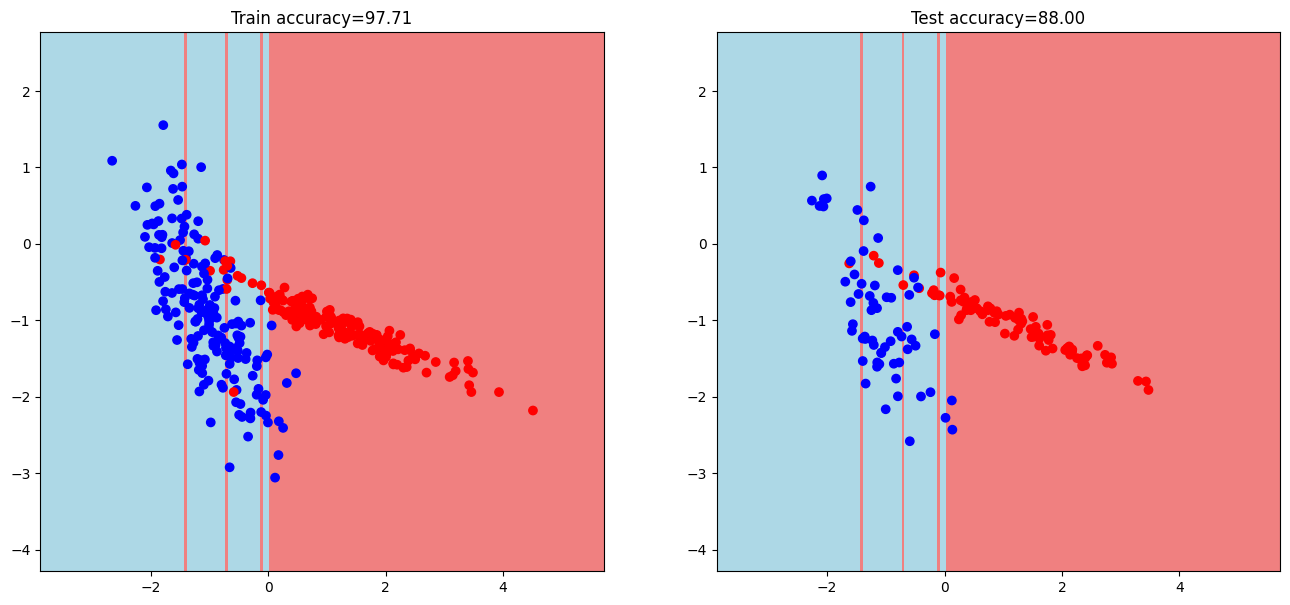

In [233]:
egg(3)

Точность случайного леса из 10 деревьев на обучающей выборке: 97.714
Точность случайного леса из 10 деревьев на тестовой выборке: 88.000


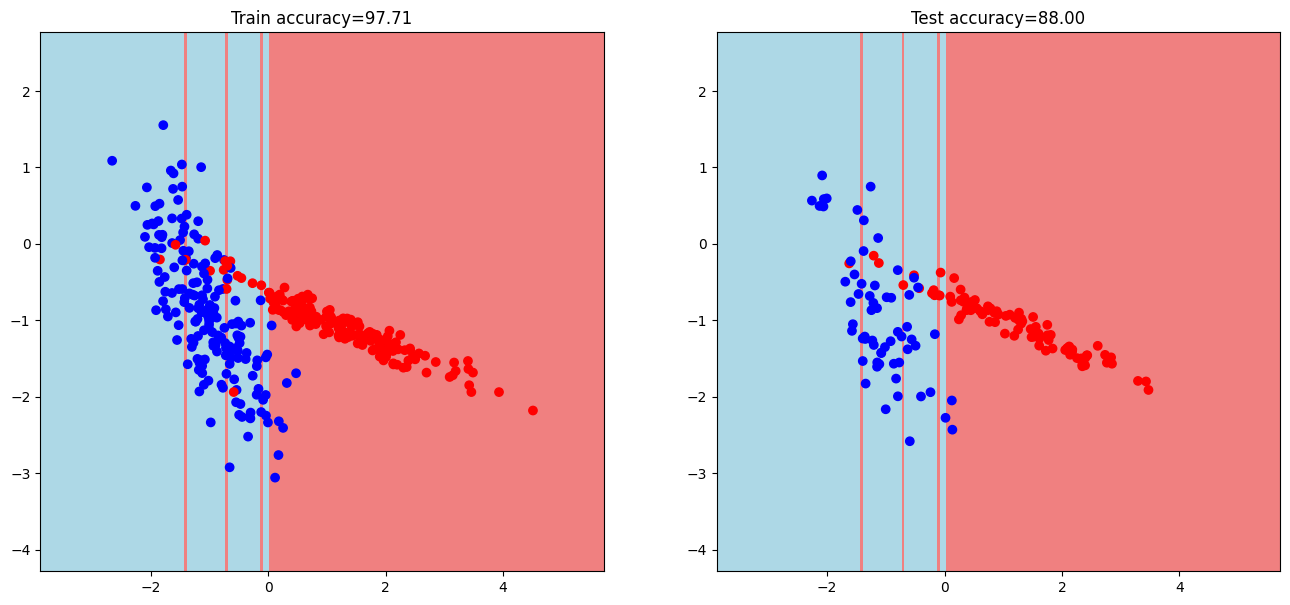

In [234]:
egg(10)

Точность случайного леса из 50 деревьев на обучающей выборке: 97.714
Точность случайного леса из 50 деревьев на тестовой выборке: 88.000


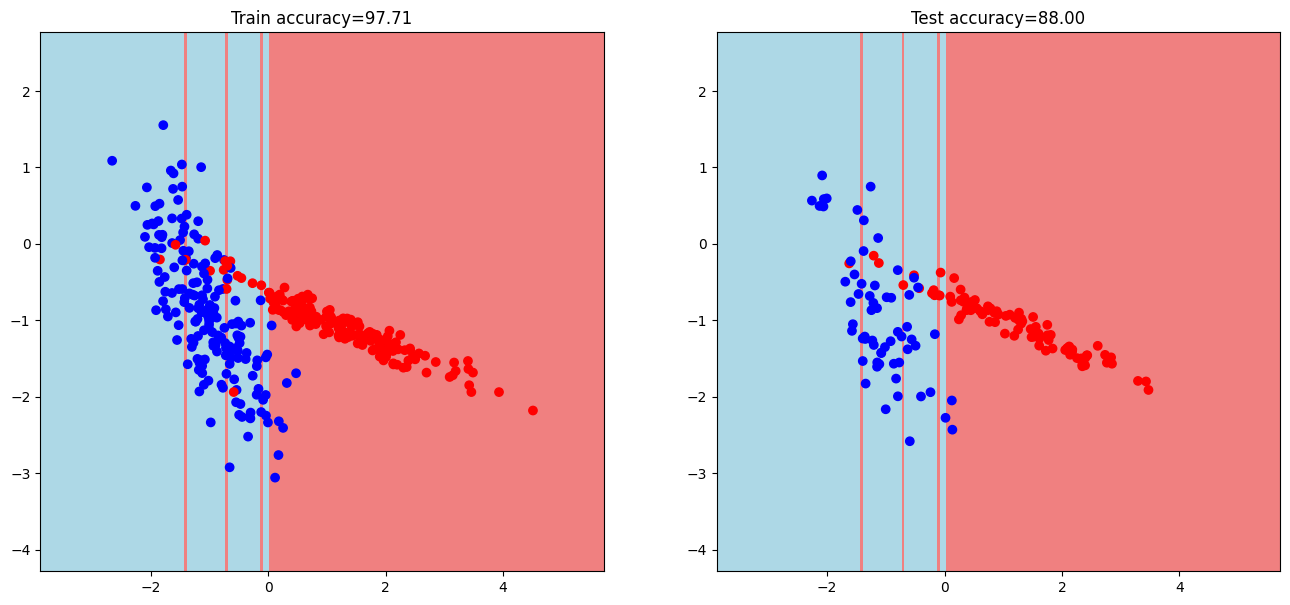

In [235]:
egg(50)